In [2]:
import numpy as np
import sdeint
import matplotlib.pyplot as plt
import math

# for plotting
from mpl_toolkits import mplot3d
import collections
import scipy.special as special



#Define constants
T = 1.0 #Temp
gamma = 20.0 #Viscosity
E_z = 10.0  #force .. ramped up from 0 to E_z
period = 6.0

B = np.sqrt(2*gamma*T)

num_sims = 5000; #number of simulations
t_f = 30.0; #simulation final time
dt = 0.01; #time step size
N = 1 + int(t_f/dt); #number of steps
ts = np.linspace(0, t_f+dt, N+1); #need the extra step for a reason...


# ramp of lamba from lambda_0 to lambda_f
lambda_0 = 0.1
lambda_f = E_z

t_ramp = 15.0; #transition time
Dt_ramp = 2.0; #transition time-scale

def ramp(z):
    "smooth ramp from 0 to 1"
    return 0.5*(1 + np.tanh(z))

def dramp(z):
    "smooth ramp from 0 to 1"
    return 0.5/(np.cosh(z)**2)

thetas = ramp((ts - t_ramp)/Dt_ramp)
dthetas = dramp((ts - t_ramp)/Dt_ramp)/Dt_ramp
lambda_s = lambda_0 + thetas*lambda_f
dlambda_s = dthetas*lambda_f
lambda_sin = 0.1+np.sin(2*np.pi/(period)*ts)
dlambda_sin = 2*np.pi/(period) * np.cos(2*np.pi/(period)*ts)


def f(x, v, lambda_):
    a = np.zeros(2)
    a[0] += -gamma*v[0]+np.cos(x[0])*np.sin(x[0])*(v[1]**2)                  # dissipation
    a[1] += -(gamma+2*np.cos(x[0])/(np.sin(x[0])+dt/5)*v[0])*v[1] # POTENTIAL TERM in z direction
    return a

def g(x, v, lambda_):
    b = np.zeros(2)
    b[0] += np.sqrt(dt)*B*np.random.normal()
    b[1] += np.sqrt(dt)*B*np.random.normal()
    return b

def force(x,lambda_):
    c = np.zeros(2)
    c[0] = -lambda_*np.sin(x[0])
    return c

#Now we need ese force
def counts(iterable, low, high, bins): #count the number of entries in a range for a given number of uniform bins
    step = (high - low + 0.0) / bins
    dist = collections.Counter((float(x) - low) // step for x in iterable)
    return [dist[b] for b in range(bins)]

#Initialize freq
num_bins= 100
freq_eq = np.zeros((num_bins,N+1)); # equilibrium
binspan = np.linspace(0, np.pi, num_bins)


for i in range(0,N+1):
    for j in range(0,num_bins):
        lambda_ = lambda_sin[i]
        freq_eq[j,i] = np.exp((lambda_/T)*np.cos(binspan[j])) * np.sin(binspan[j])
    freq_eq[:,i] /= np.sum(freq_eq[:,i])

lmax = 10

dfreq_eq_dt = np.zeros((num_bins,N));
weighted = np.zeros((lmax,num_bins,N));
ese = np.zeros((lmax,N))


for l in range(0,lmax-1): #projection onto l+1st spherical harmonic
    for i in range(0,N):
        for j in range(0,num_bins):
            dfreq_eq_dt[j,i] = 1./dt*(freq_eq[j,i+1]-freq_eq[j,i])
            weighted[l,j,i]= -gamma*dfreq_eq_dt[j,i]*special.sph_harm(0,l+1,0,binspan[j])
        ese[l,i] = -1./((l+1)*(l+2))*sum(weighted[l,:,i])

ts = np.linspace(0, t_f, N); #now go back to regular number of times


def rho(x,lambda_):
    rho = 1./((4*np.pi*T*np.sinh(lambda_/T))/lambda_)*np.exp(lambda_*np.cos(x[0])/T)
    return rho

def f_ese(l,x,k,lambda_):
    f_ese = np.zeros(2)
    f_ese[0] = np.real(ese[l-1,k]*1/rho(x,lambda_)*np.sqrt(l*(l+1))*np.exp(-1j*x[1])*special.sph_harm(1,l,x[1],x[0]))
    return f_ese

def force_ese(x,k,lambda_):
    a = np.zeros(([lmax,2]))
    for i in range(1,lmax):
        a[i] = f_ese(i,x,k,lambda_)
    return sum(a[:])

def integrator(x0, v0):
    traj = (x0,)

    x = x0
    v = v0

    for k in range(N):
        t = ts[k]
        lambda_ = lambda_sin[k]

        # --- (1) Propogate velocity ---
        v = v + dt*(f(x, v, lambda_)+force(x, lambda_)) + g(x, v, lambda_)  # ramping from lambda_0 to lambda_f
        # --- (2) Propogate position ---
        x = x + dt*v
        
        
        x[0] = math.atan2(np.sin(x[0]),np.cos(x[0]))
            
            
        if x[0] < 0:
            x[0] = -x[0]
            x[1] = x[1]+np.pi
            v[0] = -v[0]
        elif x[0]>np.pi:
            x[0] = 2*np.pi-x[0]
            x[1] = x[1]-np.pi
            v[0] = -v[0]

        x[1] = math.atan2(np.sin(x[1]),np.cos(x[1]))

            # --- (3) record onto trajectory ---
        traj += (x,)


    return np.array(traj)



def integrator_ese(x0, v0):
    traj = (x0,)

    x = x0
    v = v0

    for k in range(N):
        t = ts[k]
        lambda_ = lambda_sin[k]

        # --- (1) Propogate velocity ---
        v = v + dt*(f(x, v, lambda_)+force(x, lambda_)+f_ese(1,x,k,lambda_)+f_ese(2,x,k,lambda_)+f_ese(3,x,k,lambda_)+f_ese(4,x,k,lambda_)) + g(x, v, lambda_)  #+ ese2(x,lambda_,dlambda_) # ramping from lambda_0 to lambda_f
        # --- (2) Propogate position ---
        x = x + dt*v

        x[0] = math.atan2(np.sin(x[0]),np.cos(x[0]))

        if x[0] < 0:
            x[0] = -x[0]
            x[1] = x[1]+np.pi
            v[0] = -v[0]
        elif x[0]>np.pi:
            x[0] = 2*np.pi-x[0]
            x[1] = x[1]-np.pi
            v[0] = -v[0]

        x[1] = math.atan2(np.sin(x[1]),np.cos(x[1]))

            # --- (3) record onto trajectory ---
        traj += (x,)


    return np.array(traj)





# --- MAKES SIMULATIONS (finally!) ---
results = np.zeros([num_sims, N, 2])
results_ese = np.zeros([num_sims, N, 2])
inits = np.zeros([num_sims, 4])

for i in range(num_sims):
    print(i)
        # init position confined onto sphere
        # TODO: make rho_0 = rho_eq(t = 0)
    x0 = np.random.randn(2)
    x0[0] += 0.5*np.pi

        # init v0, with no radial component
    v0 = np.random.randn(2)


    traj = integrator(x0, v0)
    traj_ese = integrator_ese(x0, v0)

        # store results
    inits[i, :2] = x0
    inits[i, 2:] = v0
    results[i, :, :] = traj[1:, :]
    results_ese[i, :, :] = traj_ese[1:, :]





/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


0
1
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in cos


3
4
5
6
7
8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in cos
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in sin
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in cos


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in add


234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in add


713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962


2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608


4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247


In [3]:
num_bins = 40; #number of bins in histogram
step_size = np.pi/num_bins; #size of bin

def counts(iterable, low, high, bins): #count the number of entries in a range for a given number of uniform bins
    step = (high - low + 0.0) / bins
    dist = collections.Counter((float(x) - low) // step for x in iterable)
    return [dist[b] for b in range(bins)]

#Initialize freq
freq = np.zeros((num_bins,N));
freq_ese = np.zeros((num_bins,N));
freq_eq = np.zeros((num_bins,N)); # equilibrium
theta = np.zeros(N)
theta_ese = np.zeros(N)
theta_eq = np.zeros(N)

binspan = np.linspace(0, np.pi, num_bins)
binspan_eq = np.linspace(0, np.pi, num_bins)


#Fill freq: freq[j,i] is the fraction of simulations whose position at timestep i*dt is in the range -a+step_size*j < x < -a+step_size*(j+1)
for i in range(0,N):
    for j in range(0,num_bins):
        lambda_ = lambda_sin[i]
        freq[j,i] = (1./num_sims)*counts(results[:,i,0], step_size*(j-.5), step_size*(j+0.5),1)[0]
        freq_ese[j,i] = (1./num_sims)*counts(results_ese[:,i,0], step_size*(j-.5), step_size*(j+0.5),1)[0]
        freq_eq[j,i] = np.exp((lambda_/T)*np.cos(binspan[j])) * np.sin(binspan[j])
    theta_eq[i] = 0.5*np.pi*(-np.exp(-lambda_/T)+special.iv(0,lambda_/T))/np.sinh(lambda_/T)
    freq_eq[:,i] /= np.sum(freq_eq[:,i])
    theta[i] = np.mean([x for x in results[:,i,0] if 0<x<np.pi])
    theta_ese[i] = np.mean([x for x in results_ese[:,i,0] if 0<x<np.pi])
    print(i)
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


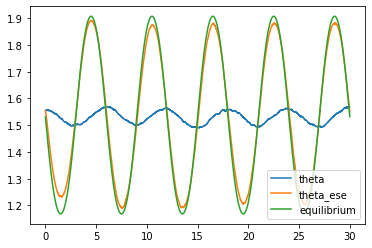

In [4]:
plt.plot(ts,theta,label='theta')
plt.plot(ts,theta_ese, label='theta_ese')
plt.plot(ts,theta_eq, label='equilibrium')
plt.legend(loc = 'best')
plt.show()



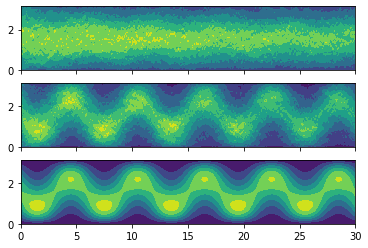

In [5]:
rho_eq = np.zeros((num_bins,N)); # equilibrium

rho_eq *= num_bins/np.pi*freq_eq
    
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.contourf(ts,binspan,freq)
ax2.contourf(ts,binspan,freq_ese)
ax3.contourf(ts,binspan,freq_eq)
plt.show()

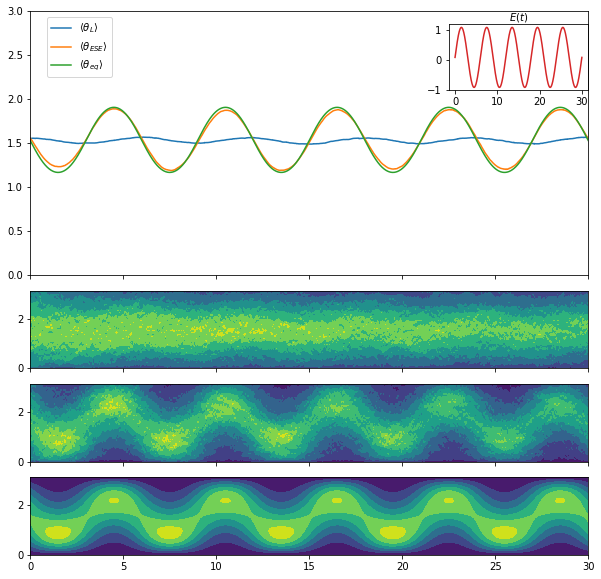

In [38]:
 from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

plt.figure(figsize=(10,10))

ax1 = plt.subplot(6,1,(1,3))
ax2 = plt.subplot(6,1,4, sharex=ax1)
ax3 = plt.subplot(6,1,5, sharex = ax1)
ax4 = plt.subplot(6,1,6, sharex = ax1)


ax1 = plt.subplot(6,1,(1,3), sharex = ax4)
ax1.plot(ts,theta,label=r'$\langle\theta_{L}\rangle$')
ax1.plot(ts,theta_ese, label=r'$\langle\theta_{ESE}\rangle$')
ax1.plot(ts,theta_eq, label=r'$\langle\theta_{eq}\rangle$')
ax1.legend(loc = [0.03,.75])
ax1.set_ylim(0.0,3.0)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax5 = plt.axes([0,1,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.75,0.70,0.25,0.25])
ax5.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
ax5.plot(ts,lambda_sin[:-1],color='C3')
ax5.text(0.5,1.20,r'$E(t)$',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax5.transAxes)





ax2.contourf(ts,binspan,freq)
ax3.contourf(ts,binspan,freq_ese)
ax4.contourf(ts,binspan,freq_eq)


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

plt.savefig('sphere2.png')

NameError: name 'left' is not defined